In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [3]:
sp500.tail(1) #Adjusted Close

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-15 00:00:00,135.354996,14.945,182.289993,175.419998,156.664993,113.779999,85.434998,370.369995,594.679993,188.050003,...,105.580002,59.075001,103.095001,33.599998,124.542,135.175003,123.080002,286.480011,41.57,189.585007


In [4]:
# Define the time period and lag, can be changed to any number and code will work
time_period = 1260  # 5 years
lag = 20 # lag of 20 days


## Momentum Factors:
 ### Parameter for calculation is used for the backtest. The backtest will run 5 years but can be changed as long as there is sufficient data downloaded.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years. It's for backtesting.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) 


    # x - x.min() / x.min() * 100 where x is the adjusted close price of our 500 stocks during the stored slice of time period
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
A,0.050728,38.096829,6.507197,0.129838,9.914193e+04
AAL,-0.015510,44.468083,-7.041694,-0.048228,9.205973e+07
AAPL,0.125001,58.452120,14.944137,0.310328,3.124254e+07
ABBV,0.081457,39.377661,10.099874,0.181843,-9.830466e+05
ABNB,NaN,35.069986,-4.975296,-0.035849,1.539187e+06
...,...,...,...,...,...
YUM,0.030674,36.242369,3.416374,0.070050,4.660231e+04
ZBH,0.005869,33.469790,-0.367904,0.028772,-8.784065e+04
ZBRA,0.063604,55.979827,3.434568,0.134037,-1.340600e+05
ZION,-0.006709,55.822662,-0.884264,0.037453,-1.652772e+06


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
TSLA    42.062161
MRNA    19.582729
NVDA    17.553319
ENPH    16.222438
NVR     15.293231
BLDR     9.870118
CMG      9.602626
AZO      9.449298
AMD      9.223160
FCX      8.319455
dtype: float64

Short Basket:
VZ     -5.130006
BXP    -5.152129
PARA   -5.282765
WBA    -5.431986
ILMN   -5.497388
WBD    -5.932828
VTRS   -6.019828
BAX    -6.174731
FIS    -6.312882
VFC    -7.827274
dtype: float64


## Creating the Back-Tested Baskets

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
NVR     18.990841
NVDA    17.254701
AMD     15.760507
CZR     13.435156
ETSY    13.201545
NFLX    12.315009
ALGN    11.331938
PAYC    11.085212
TTWO     8.168513
ENPH     8.114606
dtype: float64
Short Basket Past 5 Years:
KMI   -4.936328
F     -5.000295
BEN   -5.194739
HWM   -5.229278
APA   -5.501162
MCK   -5.516376
CMG   -5.605707
SLB   -5.644123
EQT   -6.511679
GE    -6.681026
dtype: float64


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/4230148870.py:31: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean()
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/4230148870.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change


## Cumulative Returns

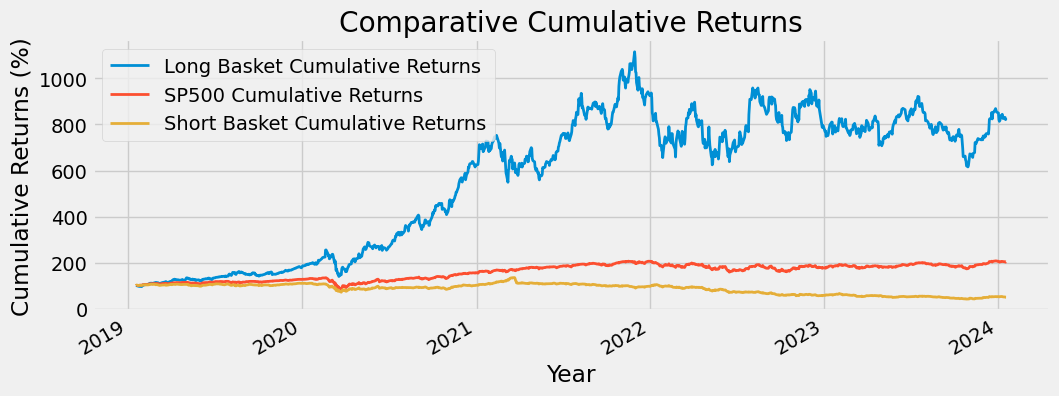

In [10]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

In [11]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
826.2408500992582
Short Basket Cumulative Returns: Most current day
50.35565741794339
SP500 Cumulative Returns: Most current day
203.99946734422673


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/4247151251.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(long_cumulative_returns[-1])
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/4247151251.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(short_cumulative_returns[-1])
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/4247151251.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

In [12]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-02-15 Long Basket has outperformed the SP500 by 622.2413827550315 percentage points
As of 2024-02-15 Short Basket has underperformed the SP500 by -153.64380992628332 percentage points


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/662054573.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/662054573.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_15370/386899937.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = dataf.pct_change()


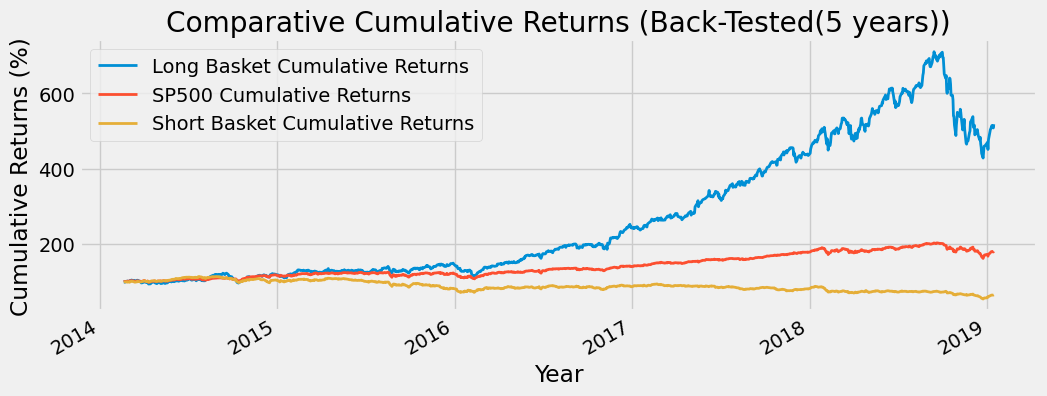

In [13]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns (Back-Tested(5 years))')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Return Bar Charts (Pos/Neg coloring) vs SP500

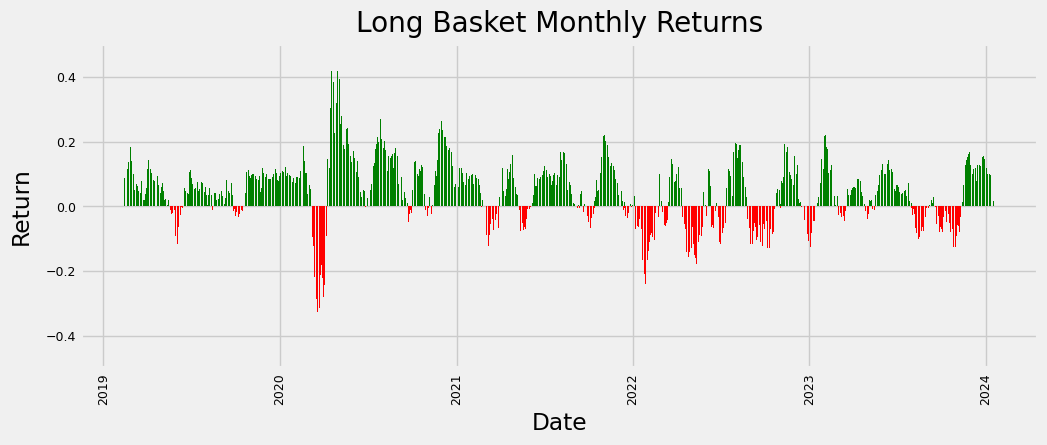

In [14]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

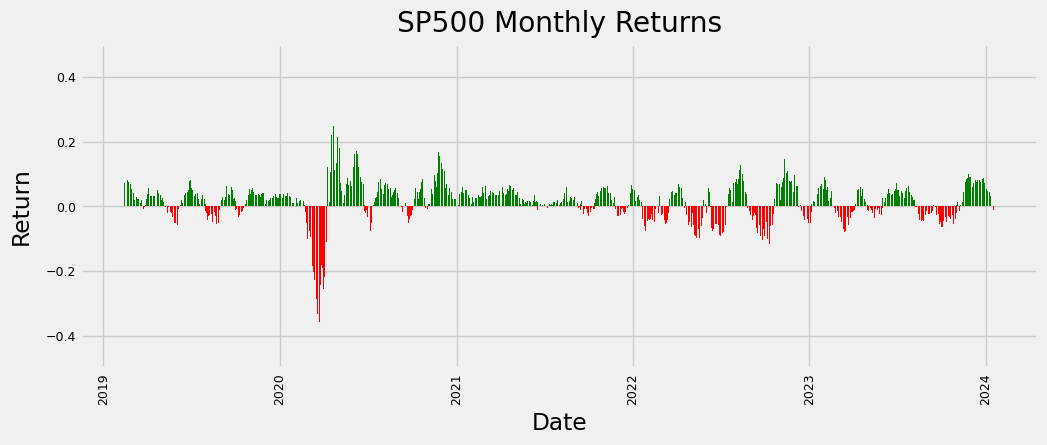

In [15]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

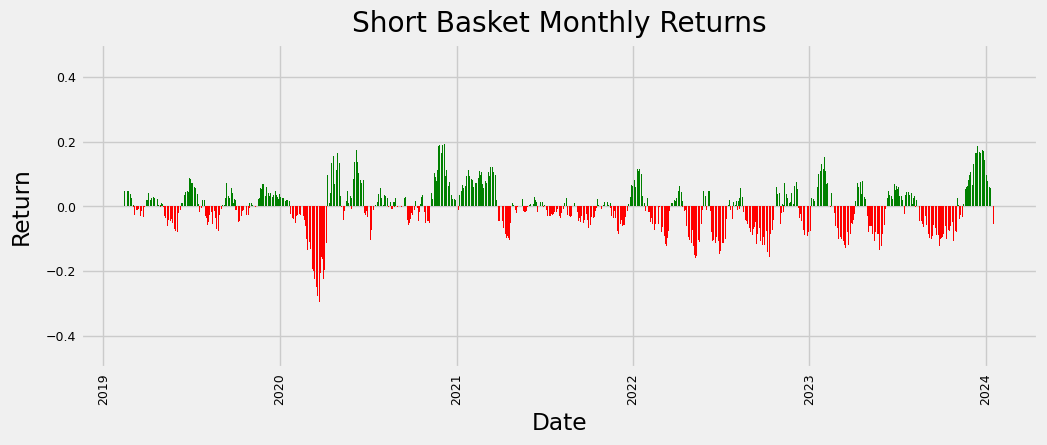

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Monthly return for long picks vs short picks vs SP500

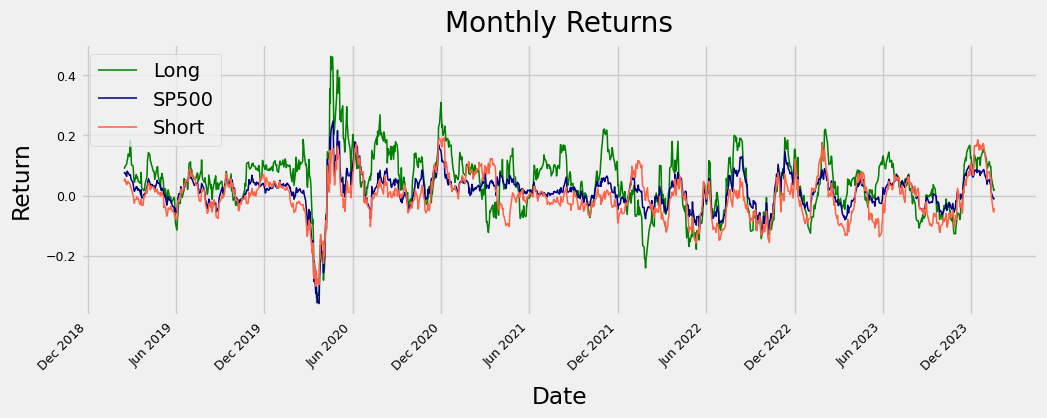

In [17]:
# Three plots 
plt.style.use('fivethirtyeight')
long_monthly_returns.plot(figsize=(11,4), label = 'Long', color = 'g', lw=1.1)
monthly_returns.plot(figsize=(11,4), label = 'SP500', color ='navy', lw = 1.1)
short_monthly_returns.plot(figsize=(11,4),label= 'Short', color = 'tomato', lw=1.1)

# Plot configurations 
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y',))
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=9)
plt.ylabel('Return',labelpad=9)
plt.xlabel('Date',labelpad=9)
plt.title('Monthly Returns',pad=9)
plt.show()

# Extra Credit : Portfolio weights
## Imported class from Efficient Frontier 

In [18]:
%%capture 
import os
import sys
# ^ this is used to suppress the output of the cell

# Getting the directory for the module were going to import
current_dir = os.getcwd()[:-17] #removing the last 17 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

In [19]:
ef = EfficientFrontier(sp500[long_basket.index])
ef.calculate_portfolio() #Printing Annual Returns

TSLA    1.418842
MRNA    1.574506
NVDA    1.618590
ENPH    1.612043
NVR     1.231629
BLDR    1.441183
CMG     1.212569
AZO     1.192933
AMD     1.548638
FCX     1.170391
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


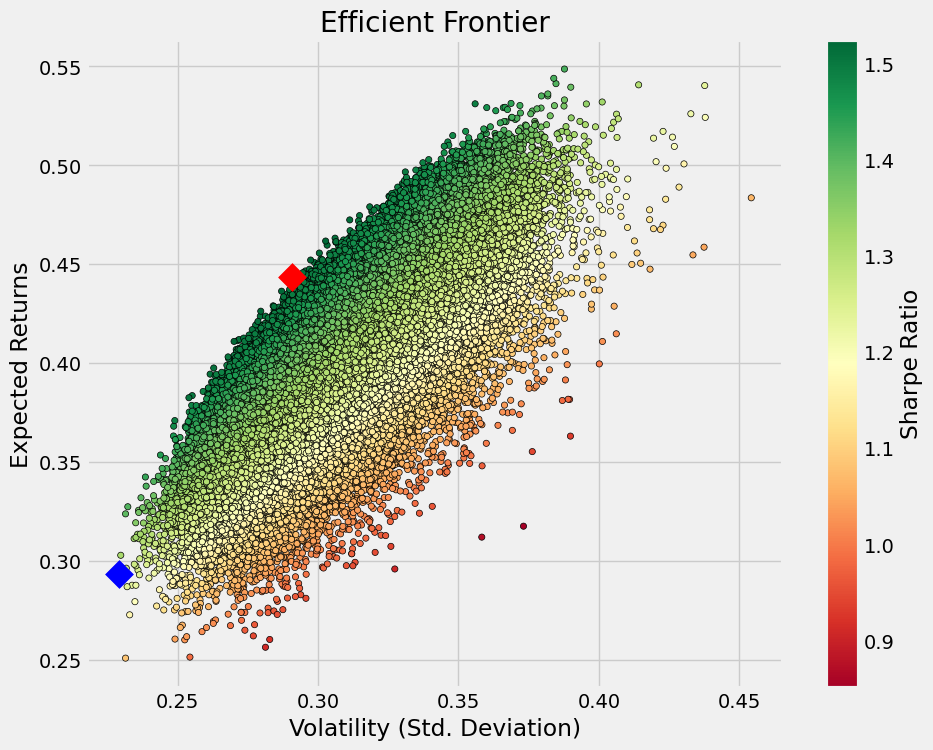

In [20]:
ef.plot_frontier()

In [21]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.293129                  0.443310
Volatility                        0.228977                  0.290620
Sharpe Ratio                      1.280169                  1.525395
TSLA Weight                       0.003314                  0.004864
MRNA Weight                       0.112095                  0.139973
NVDA Weight                       0.093934                  0.244086
ENPH Weight                       0.000712                  0.040736
NVR Weight                        0.329809                  0.031741
BLDR Weight                       0.005461                  0.135134
CMG Weight                        0.058285                  0.071386
AZO Weight                        0.300035                  0.209264
AMD Weight                        0.008729                  0.109689
FCX Weight                        0.087626                  0.013126
